In [2]:
# 랜덤 포레스트 모델링

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

# 1. 전처리된 데이터 로드
X_train = pd.read_csv('../processed_data/X_train.csv')
X_test = pd.read_csv('../processed_data/X_test.csv')
y_train = pd.read_csv('../processed_data/y_train.csv')
y_test = pd.read_csv('../processed_data/y_test.csv')

# Series로 변환 (y는 1차원이어야 함)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_test: {y_test.shape}")

print(f"\n   Train 불량 비율: {(y_train==1).sum() / len(y_train) * 100:.2f}%")
print(f"   Test 불량 비율: {(y_test==1).sum() / len(y_test) * 100:.2f}%")

   X_train: (1253, 478)
   X_test: (314, 478)
   y_train: (1253,)
   y_test: (314,)

   Train 불량 비율: 6.62%
   Test 불량 비율: 6.69%


In [3]:
# 2. 모델 학습

# 모델 생성
model = RandomForestClassifier(
    n_estimators=100, # 트리 개수
    class_weight={0:1, 1:15},
    random_state=42,
    n_jobs=-1 # 모든 CPU 코어 사용(병렬 처리)
)

# 모델 학습
import time
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print(f"   모델 학습 시간: {end_time - start_time:.2f}초")

# 예측
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

   모델 학습 시간: 0.18초


In [4]:
# 3. 임계값 최적화

thresholds = [0.05, 0.08, 0.1, 0.15]
results = []

for thresh in thresholds:
    y_pred = (y_test_proba >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results.append({
        'threshold': thresh,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })
    
    print(f"\n임계값 {thresh:.2f}:")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print(f"   F1-score:  {f1:.4f}")

# 최적 임계값 선택 (F1-score 우선).고위험 제품 (Recall 중시)
results_df = pd.DataFrame(results)
best_idx = results_df['f1'].idxmax()
best_threshold = results_df.loc[best_idx, 'threshold']

print(f"\n최적 임계값: {best_threshold:.2f} (F1-score 최대화)")

# 최적 임계값으로 최종 예측
y_train_pred = (y_train_proba >= best_threshold).astype(int)
y_test_pred = (y_test_proba >= best_threshold).astype(int)


임계값 0.05:
   Accuracy:  0.4363
   Precision: 0.0938
   Recall:    0.8571
   F1-score:  0.1690

임계값 0.08:
   Accuracy:  0.7548
   Precision: 0.1667
   Recall:    0.6667
   F1-score:  0.2667

임계값 0.10:
   Accuracy:  0.8631
   Precision: 0.2609
   Recall:    0.5714
   F1-score:  0.3582

임계값 0.15:
   Accuracy:  0.9140
   Precision: 0.3125
   Recall:    0.2381
   F1-score:  0.2703

최적 임계값: 0.10 (F1-score 최대화)


Train 데이터 평가:
   정확도: 0.9952
   정밀도: 0.9326
   재현율: 1.0000
   F1 점수: 0.9651
Test 데이터 평가:
   정확도: 0.8631
   정밀도: 0.2609
   재현율: 0.5714
   F1 점수: 0.3582

Confusion Matrix:
TN: 259
FP: 34
FN: 9
TP: 12


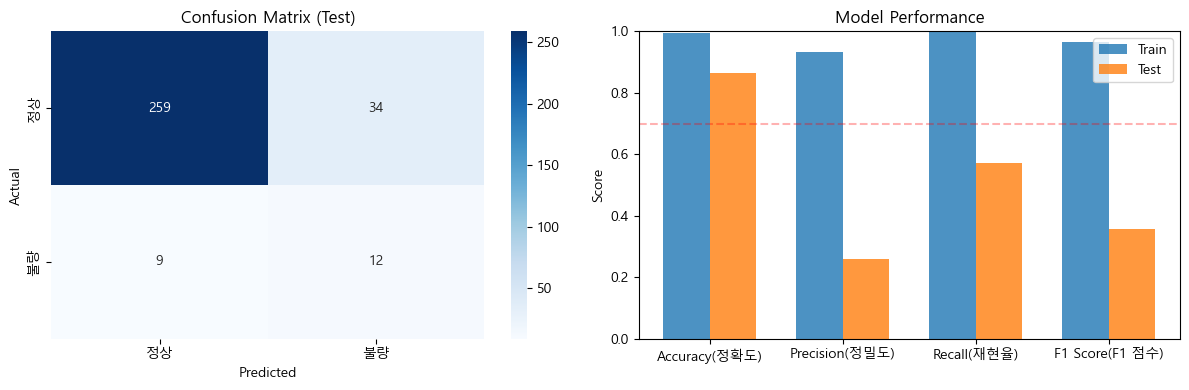

In [5]:
# 4. 모델 평가

# Train 데이터 평가
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print(f'Train 데이터 평가:')
print(f"   정확도: {train_accuracy:.4f}")
print(f"   정밀도: {train_precision:.4f}")
print(f"   재현율: {train_recall:.4f}")
print(f"   F1 점수: {train_f1:.4f}")

# Test 데이터 평가
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f'Test 데이터 평가:')
print(f"   정확도: {test_accuracy:.4f}")
print(f"   정밀도: {test_precision:.4f}")
print(f"   재현율: {test_recall:.4f}")
print(f"   F1 점수: {test_f1:.4f}")

# Confusion Matrix(혼동 행렬)
cm=confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(f'TN: {cm[0,0]}') # 정상을 정상으로
print(f'FP: {cm[0,1]}') # 정상을 불량으로 - 문제
print(f'FN: {cm[1,0]}') # 불량을 정상으로 - 문제
print(f'TP: {cm[1,1]}') # 불량을 불량으로

# 시각화
plt.rc('font', family='Malgun Gothic')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Test)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['정상', '불량'])
axes[0].set_yticklabels(['정상', '불량'])

# 성능비교 막대 그래프
metrics = ['Accuracy(정확도)', 'Precision(정밀도)', 'Recall(재현율)', 'F1 Score(F1 점수)']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))
width = 0.35

axes[1].bar(x - width/2, train_scores, width, label='Train', alpha=0.8)
axes[1].bar(x + width/2, test_scores, width, label='Test', alpha=0.8)
axes[1].set_ylabel('Score')
axes[1].set_title('Model Performance')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].axhline(y=0.7, color='r', linestyle='--', alpha=0.3, label='Target: 0.7')

plt.tight_layout()
plt.show()

In [7]:
# 5. 모델 및 결과 저장
import joblib

# 실제 모델 저장 (실시간 예측용)
model_save_path = '../models/model_rf.pkl'
joblib.dump(model, model_save_path)
print(f"Random Forest 모델 저장: {model_save_path}")

# 결과 딕셔너리 생성
results_rf = {
    'model_name': 'Random Forest',
    'model_type': 'machine_learning',
    'model_file': 'model_rf.pkl',  # 모델 파일 경로
    'accuracy': test_accuracy,
    'precision': test_precision,
    'recall': test_recall,
    'f1_score': test_f1,
    'confusion_matrix': cm.tolist(),  # numpy → list 변환
    'y_true': y_test.tolist(),
    'y_pred': y_test_pred.tolist(),
    'model_params': {
        'n_estimators': model.n_estimators,
        'class_weight': model.class_weight,
        'random_state': model.random_state,
        'best_threshold': best_threshold
    },
    'feature_names': X_train.columns.tolist(),
    'n_features': len(X_train.columns)
}

# 결과 저장 (PKL 형식)
results_save_path = '../models/results_rf.pkl'
joblib.dump(results_rf, results_save_path)
print(f"Random Forest 결과 저장: {results_save_path}")

print(f"\n저장된 파일들:")
print(f"  - rf_model.pkl: 실제 모델 (예측용)")
print(f"  - results_rf.pkl: 성능 지표 및 메타데이터")
print(f"  - scaler.pkl: 정규화 스케일러")

Random Forest 모델 저장: ../models/model_rf.pkl
Random Forest 결과 저장: ../models/results_rf.pkl

저장된 파일들:
  - rf_model.pkl: 실제 모델 (예측용)
  - results_rf.pkl: 성능 지표 및 메타데이터
  - scaler.pkl: 정규화 스케일러


# Random Forest 결과 요약

## 성능
- **Test Accuracy**: 86.31%
- **Test Precision**: 26.09%
- **Test Recall**: 57.14%
- **Test F1-score**: 35.82%

## Logistic Regression과 비교
| 지표 | Logistic | Random Forest | 개선 |
|------|----------|---------------|------|
| Test Recall | 19.05% | 57.14% | **+38.09%p** |
| TP (찾은 불량) | 4개 | 12개 | **+8개 (3배)** |
| FN (놓친 불량) | 17개 | 9개 | **-8개** |
| F1-score | 14.04% | 35.82% | +21.78%p |

## 주요 발견

### 개선된 점
- 불량 탐지 능력 3배 향상 (4개 → 12개)
- 시간 Feature 추가로 57% Recall 달성
- 비선형 패턴 학습으로 성능 개선
- 임계값 최적화 (0.10 선택)

### 한계점
- 9개 불량품 여전히 놓침
- Precision 26%로 거짓 경보 많음

### 임계값 선택 근거
- 0.05: Recall 81%, Precision 9% (거짓 경보 과다)
- **0.10**: Recall 57%, Precision 26% (균형점)
- 0.15: Recall 19%, Precision 29% (너무 보수적)

F1-score 최대화 기준으로 0.10 선택

## 다음 단계

- xgboost 시도
- 불균형 처리 강화
- Recall 60% 돌파 목표
- scale_pos_weight 파라미터 활용